<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3 : Scalling up (Food vision mini 🍔)

we have seen the power of feature extraction and fine-tunning and now we want to scall up to 101food all classes.

our gool is to make accurate prediction on 10% of 101food dataset classes (leverage patterns by 10% of data)

   `

## 0. Prerequirities

In [ ]:
!pip install tensorflow==2.13

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import pathlib
import os
import random

In [ ]:
# checking we are using a GPU
!nvidia-smi

Wed Sep 20 09:49:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# getting helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# importing functions we want use them
from helper_functions import create_tensorboard_callback , plot_loss_curves , walk_through_dir , unzip_data , compare_historys , make_confusion_matrix

--2023-09-20 09:49:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.002s  

2023-09-20 09:49:22 (4.78 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 2. Prepare data

In [ ]:
# Download our data set files
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-09-20 09:49:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.207, 173.194.197.207, 64.233.191.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  94.1MB/s    in 16s     

2023-09-20 09:49:39 (94.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# unzip downloaded data
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
# setting train and test directory variables
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [ ]:
# making train and test data
# train
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                 batch_size = 32 ,
                                                                 label_mode = "categorical" ,
                                                                 image_size =(224,224))

# test
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                batch_size = 32 ,
                                                                label_mode = "categorical" ,
                                                                image_size = (224,224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# creating data augmentation
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2) ,
    preprocessing.RandomZoom(0.2) ,
    preprocessing.RandomHeight(0.2) ,
    preprocessing.RandomWidth(0.2) ,
    preprocessing.RandomFlip("horizontal")
] ,name = "data_augmentation")

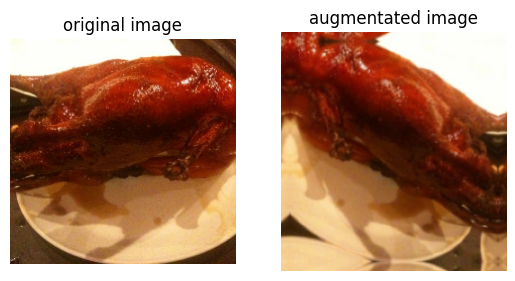

In [ ]:
# visualizing an augmentated image
# np.random.seed(42) # it doesn't do anything
image_array = list(iter(train_data))
random_number_1 = np.random.randint(low = 0 , high = (len(image_array)-1))
random_number_2 = np.random.randint(low = 0 , high = (len(image_array[random_number_1][0])-1))
img = image_array[random_number_1][0][random_number_2]
plt.subplot(1,2,1) ;
plt.imshow(img/255.0) ;
plt.axis("off") ;
plt.title("original image") ;
plt.subplot(1,2,2) ;
plt.imshow(data_augmentation(img/255.0)) ;
plt.axis("off") ;
plt.title("augmentated image") ;

## 3. Build Model

### Feature Extraction

In [ ]:
# create base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# create layers
inputs = tf.keras.Input(shape = (224,224,3) , name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x , training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_max_pooling_2d")(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names) , activation = tf.keras.activations.softmax , name = "output_layer")(x)
model = tf.keras.Model(inputs , outputs)

16705208/16705208 [==============================] - 0s 0us/step


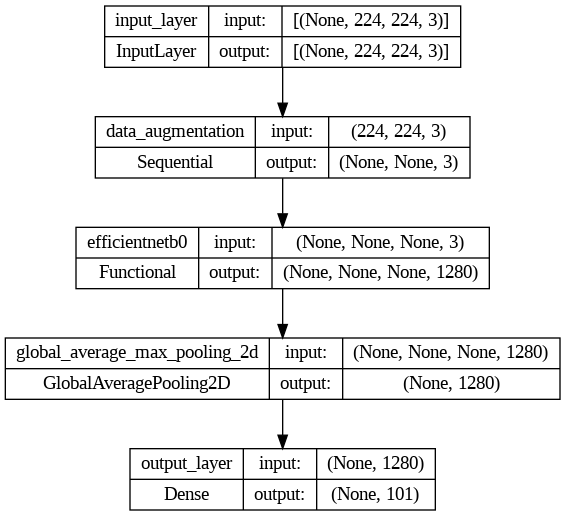

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model , show_shapes = True)

In [ ]:
# make checkpoint callback
checkpoint_path = "101_all_classes_10_percent_data"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path ,
                                                         save_weights_only = True ,
                                                         save_best_only = True ,
                                                         monitor = "val_accuracy")

In [ ]:
# compile model
model.compile(loss = tf.keras.losses.categorical_crossentropy ,
              optimizer = tf.keras.optimizers.Adam() ,
              metrics = ["accuracy"])
# fit model
feature_extraction_result = model.fit(epochs = 5 ,
                                      x = train_data ,
                                      steps_per_epoch = len(train_data) ,
                                      validation_data = test_data ,
                                      validation_steps = len(test_data))

Epoch 1/5
237/237 [==============================] - 227s 882ms/step - loss: 3.3855 - accuracy: 0.2640 - val_loss: 2.3053 - val_accuracy: 0.4830
Epoch 2/5
237/237 [==============================] - 164s 690ms/step - loss: 2.2034 - accuracy: 0.4995 - val_loss: 1.8794 - val_accuracy: 0.5367
Epoch 3/5
237/237 [==============================] - 133s 560ms/step - loss: 1.8346 - accuracy: 0.5625 - val_loss: 1.7205 - val_accuracy: 0.5598
Epoch 4/5
237/237 [==============================] - 139s 583ms/step - loss: 1.6062 - accuracy: 0.6115 - val_loss: 1.6405 - val_accuracy: 0.5717
Epoch 5/5
237/237 [==============================] - 158s 667ms/step - loss: 1.4594 - accuracy: 0.6432 - val_loss: 1.5886 - val_accuracy: 0.5811


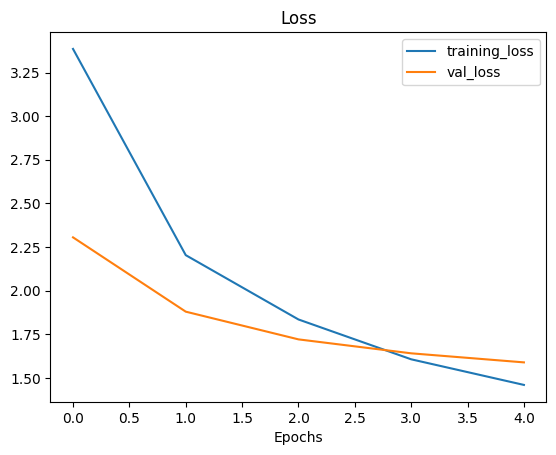

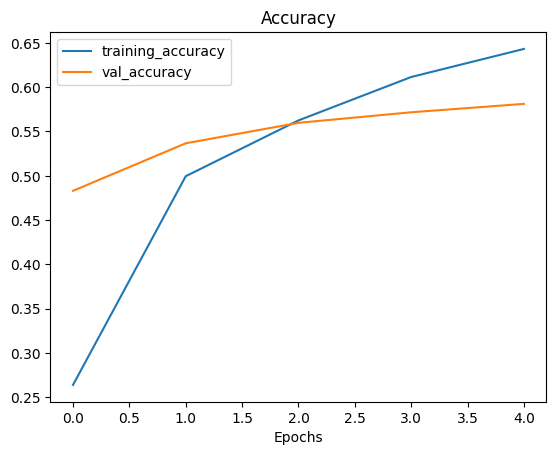

In [ ]:
plot_loss_curves(feature_extraction_result)

### Fine-Tunning

In [ ]:
# a glance at model layers
for i , layer in enumerate(base_model.layers) :
  print(i , layer.name , layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# making last 10 layers trinable
for i in range(len(base_model.layers[-10:])) :
  base_model.layers[-10:][i].trainable = True

In [ ]:
# checking the trainability of last layers
for i , layer in enumerate(base_model.layers[-15:]) :
  print(i , layer.name , layer.trainable)

0 block7a_expand_bn False
1 block7a_expand_activation False
2 block7a_dwconv False
3 block7a_bn False
4 block7a_activation False
5 block7a_se_squeeze True
6 block7a_se_reshape True
7 block7a_se_reduce True
8 block7a_se_expand True
9 block7a_se_excite True
10 block7a_project_conv True
11 block7a_project_bn True
12 top_conv True
13 top_bn True
14 top_activation True


In [ ]:
# recompile model
model.compile(loss = tf.keras.losses.categorical_crossentropy ,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) ,
              metrics = ["accuracy"])
# fit model
fine_tunned_result = model.fit(epochs = 10 ,
                               x = train_data ,
                               steps_per_epoch = len(train_data) ,
                               validation_data = test_data ,
                               validation_steps = len(test_data) ,
                               initial_epoch = feature_extraction_result.epoch[-1])

Epoch 5/10
237/237 [==============================] - 171s 664ms/step - loss: 1.3710 - accuracy: 0.6562 - val_loss: 1.5508 - val_accuracy: 0.5880
Epoch 6/10
237/237 [==============================] - 132s 554ms/step - loss: 1.2308 - accuracy: 0.6891 - val_loss: 1.5334 - val_accuracy: 0.5933
Epoch 7/10
237/237 [==============================] - 153s 644ms/step - loss: 1.1387 - accuracy: 0.7168 - val_loss: 1.5325 - val_accuracy: 0.5901
Epoch 8/10
237/237 [==============================] - 182s 767ms/step - loss: 1.0625 - accuracy: 0.7410 - val_loss: 1.5117 - val_accuracy: 0.5943
Epoch 9/10
237/237 [==============================] - 162s 677ms/step - loss: 0.9919 - accuracy: 0.7593 - val_loss: 1.5139 - val_accuracy: 0.5925
Epoch 10/10
237/237 [==============================] - 137s 569ms/step - loss: 0.9382 - accuracy: 0.7683 - val_loss: 1.5124 - val_accuracy: 0.5937


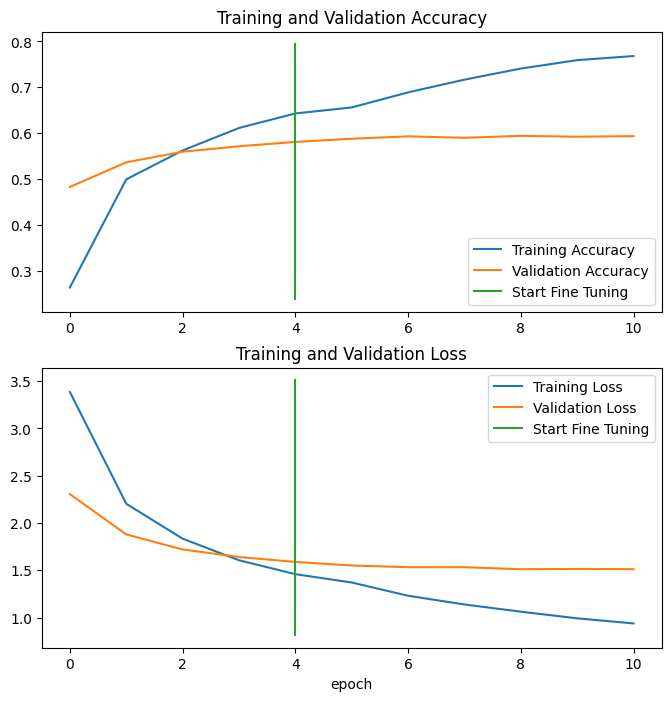

In [ ]:
compare_historys(original_history = feature_extraction_result ,
                 new_history = fine_tunned_result ,
                 initial_epochs = 5)

In [ ]:
model_evaluation = model.evaluate(test_data)
model_evaluation

790/790 [==============================] - 93s 116ms/step - loss: 1.5124 - accuracy: 0.5937


[1.512387990951538, 0.5936633944511414]

### Save Model

❗ **Note**

Actully for saving my model tensorflow brings an error this error appears in v2.10 and later and doesn't appears on v2.9 and older versions

In [ ]:
# save our trained model for further usages
model.save("drive/MyDrive/101_food_classes_10_percent_model")

In [ ]:
!ls 'drive/MyDrive'

101_food_classes_10_percent_model


## 4. Trying another Model

In [ ]:
# Downloading model data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-09-20 10:22:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 64.233.182.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  94.6MB/s    in 0.5s    

2023-09-20 10:22:35 (94.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# unzip model data
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load model
loaded_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# make evaluations
loaded_model_evaluation =  loaded_model.evaluate(test_data)
loaded_model_evaluation

790/790 [==============================] - 88s 107ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027223348617554, 0.6077623963356018]

In [ ]:
# compare models
np.isclose(loaded_model_evaluation , model_evaluation)

array([False, False])

**Conclusion**

so our downloaded preforms **better** than our trained model so we use that for making predictions

## 5. Evaluating our model predictions

### make predictions

In [ ]:
# making prediction (grtting prediction probilities)
pred_probs = loaded_model.predict(test_data)

790/790 [==============================] - 84s 103ms/step


In [ ]:
# a glance at prediction lables
pred_probs.shape

(25250, 101)

In [ ]:
# predction probilities actully preforms the posibility of every class for predctions done by model
# and as we know the sum of the posibility of all states equalls 1 per image that means totally 25250
tf.round((pred_probs.sum())).numpy()

25250.0

In [ ]:
# getting prediction lables from predction probilities
pred_lables = pred_probs.argmax(axis = 1)

In [ ]:
# predction lables gives us the most possible class for our image
pred_lables.shape

(25250,)

In [ ]:
# finding the correct lables of images
y_lables = []
for image , label in test_data.unbatch() :
  y_lables.append(label.numpy().argmax())
y_lables[-10:]

[18, 77, 27, 100, 78, 52, 45, 10, 13, 68]

In [ ]:
list(pred_lables[-10:])

[47, 82, 22, 90, 91, 63, 35, 20, 31, 40]

### sklearn `accuracy score` function

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_lables ,
                                  y_pred = pred_lables)
sklearn_accuracy

0.011564356435643564

In [ ]:
np.isclose(sklearn_accuracy , loaded_model_evaluation[1])

False

### sklearn tools for visualizing the `Confusion Matrix`

In [ ]:
make_confusion_matrix(y_true = y_lables ,
                      y_pred = pred_lables ,
                      classes = train_data.class_names ,
                      figsize = (100,100) ,
                      text_size = 20 ,
                      savefig = True )

### sklearn `classification report`

In [ ]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_true = y_lables,
                                                   y_pred = pred_lables)

In [ ]:
# for nitter perform
print(classification_report(y_true = y_lables,
                            y_pred = pred_lables))

### finding most correct and wrong predictions

In [ ]:
class_f1_score = {}

for v , c in classification_report_dict.items() :
  if v == "accuracy" :
    break
  else :
    class_f1_score[class_names[int(v)]] = v["f1-score"]

class_f1_score

In [ ]:
f1_scores = pd.DataFrame({"class_names" : list(class_f1_score.keys()),
                          "f1-score" : list(class_f1_score.values())}).sort_values("f1_score" , ascending = False)

In [ ]:
f1_scores[:5]

In [ ]:
fig , ax = plt.subplot(figsize = (12,25))
scores = ax.brah(range(len(f1_scores)) , f1_scores["f1_score"].values)
# ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis() ;

### visualizing predcitions on test images  

In [ ]:
from helper_functions import load_and_prep_image

In [ ]:
pred_probs[:5]

NameError: ignored